# MIS 583 Assignment 5-2(bouns): Generative Adversarial Network(GAN)

This tutorial was originally written by [Nathan Inkawhich](https://github.com/inkawhich) for PyTorch Offical Tutorial.

This version has been adapted by [Simon Chung](https://github.com/simonchung87) for NSYSU MIS 583 assigment.


Refrence:
- DCGAN - PyTorch offical tutorial  
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- Self-Normalizing Neural Networks  
https://arxiv.org/abs/1706.02515
- Relativistic GAN  
https://arxiv.org/abs/1807.00734

Tutorial or Source code:
- SELU make funs great again  
https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
- Relativistic GAN offical GitHub **(important)**  
https://github.com/AlexiaJM/RelativisticGAN
- third party Relativistic repo - ririw  
https://github.com/ririw/Relativistic-GAN/blob/master/relgan/trainer.py


## Generative Adversarial Network(GAN)

"GAN and its variations that are now being proposed is the most interesting idea in the last 10 years in ML, in my opinion." LeCun has ever said.

GAN was designed by Ian Goodfellow in 2014 is an approach contains generator and discirminator.

Though originally proposed as a form of generative model for **unsupervised learning**, GANs have also proven useful for **semi-supervised learning**, **fully supervised learning** and **reinforcement learning**.



### What is GAN

GAN contains generator and discirminator.

Generator's primary goal is fool the discriminator, make loss of discriminator maximum.

In contrast, disciminator's main goal is corretly classifiy whether  a image(or data) is real(from original dataset) or fake(made by generator).

In this tutorial, we will cover:
- GAN
- DCGAN
- SELU
- Relativistic GAN
- or any advanced GAN you interested in

This assignment will walk you through implementing a DCGAN sing the CelebA dataset in PyTorch and apply some advanced modifications.

In [ ]:
!python3 --version
!pip3 freeze | grep torch

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101


## Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install patool
import patoolib
patoolib.extract_archive("foo_bar.rar", outdir="path here")

In [ ]:
!mkdir data
!unzip -qq -n ./drive/My\ Drive/celeba_dataset.zip -d data/celeba

mkdir: cannot create directory ‘data’: File exists


### Load Data

In [ ]:
import torch
import torch.utils.data as data
from torchvision import transforms, datasets

We can load it just use torchvision

In [ ]:
def get_celeba(root, split, download=False):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])
    return datasets.CelebA(root, split=split, transform=transform,
        download=download)

def get_data():
    dataset_train = get_celeba('./data', 'train',)
    dataset_test = get_celeba('./data', 'test')
    print('train', len(dataset_train))
    print('test', len(dataset_test))
    return dataset_train, dataset_test

dataset_train, dataset_test = get_data()

train 162770
test 19962


In [ ]:
batch_size = 32
img_size = 64
train_data = data.DataLoader(dataset_train, batch_size=batch_size,
                             drop_last=True, shuffle=True)
test_data = data.DataLoader(dataset_test, batch_size=batch_size,
                             drop_last=True)

Let's sample some images and plot them.

In [ ]:
import matplotlib.pyplot as plt

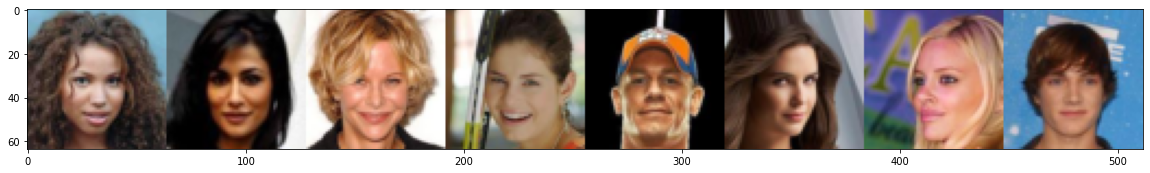

In [ ]:
def plot_imgs(img, save_file=False, file_name='out'):
    img = img.permute(1, 2, 0, 3).reshape(3, img_size, -1)
    img = (img + 1) / 2
    plt.figure(figsize=(20,10))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    if save_file:
        plt.savefig(file_name)

plot_imgs(next(iter(train_data))[0][:8])

## Build Model
### DCGAN

[DCGAN](https://arxiv.org/abs/1511.06434) (Deep Convolutional Generative Adversarial Network) was proposed in 2015.

It use ConvTransposed(逆捲積) to build generator.

Discriminator is normal classification using Convolution.

![](https://i.imgur.com/NhERHis.png)

**DCGAN has been a excellent base strucutre of GAN using convolution.**


### SELU

There are some disadvantages in DCGAN.  
DCGAN can't be trained with high learn rate, it is easy to cause gradient vanishing.  
Recently, some research change the loss function or activation to increase the stability of GAN.    
**SELU** is a activation that was proved outperform many existing methods in Feed-Forward Neural Network.  
High-resolution DCGAN paper mentioned BatchNorm + ReLU could be replaced with SELU.

$$
\text{selu}(x) = \lambda \left\{
\begin{aligned}
    & x & if & x > 0 \\
    & \alpha e^x - \alpha & if & x \leq 0
\end{aligned}
\right. \\
\alpha = 1.6732, \lambda = 1.0507
$$


### Relativistic GAN

Relativistic GAN was proprosed in 2018.  
Old GAN discriminator only tend to make fake data more similar to real data.  
Ideal generator should also make real data fake(lost piece of original GAN) and make fake data real(original GAN).  
It will increase stability and coverage into lower reconstruction loss.

(A) 是如果用 divergence minimization 可以達到的效果，(B) 是目前 GAN 實際上用 loss 訓練，(C) 是 Relativistic GAN 的理想的優化

![](https://i.imgur.com/JxiCksr.png)

More detail please check out paper

In [ ]:
import torch.nn as nn
import torch.nn.functional as F



latent_dim = 100
g_hidden = 128 # hidden dim of generator
d_hidden = 128 # hidden dim of discriminator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- You Should Modify ----------
        # TODO: add activation
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, g_hidden * 8,
                kernel_size=4, stride=1, padding=0, bias=False),
                nn.SELU(True),
        
        
            nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4,
                  kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(True),


            nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(True),

            nn.ConvTranspose2d(g_hidden * 2, g_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(True),

            nn.ConvTranspose2d(g_hidden, 3,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- You Should Modify ----------
        # TODO: add activation
        self.main = nn.Sequential(
            nn.Conv2d(3, d_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
            # --> some regularization and activation
            # shape is (d_hidden, 32, 32),

            nn.Conv2d(d_hidden, d_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(True),
            # --> some regularization and activation
            # shape is (d_hidden * 2, 16, 16),

            nn.Conv2d(d_hidden * 2, d_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(True),
            # --> some regularization and activation
            # shape is (d_hidden * 4, 8, 8),

            nn.Conv2d(d_hidden * 4, d_hidden * 8,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(True),
            # --> some regularization and activation
            # shape is (d_hidden * 8, 4, 4),

            nn.Conv2d(d_hidden * 8, 1,
                kernel_size=4, stride=1, padding=0, bias=False),
            # shape is (1, 1, 1)
            #nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__

    # ---------- You Should Modify ----------
    # TODO: correct weight initialization
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 1/img_size)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)##################


### Test Model
Let's test our model output shape with simulated data input.

In [ ]:
def test_model():
    net_d = Discriminator()
    net_g = Generator()

    x = torch.rand(16, latent_dim, 1, 1)

    out = net_g(x)
    print(out.shape)
    out2 = net_d(out)
    print(out2.shape)
test_model()

torch.Size([16, 3, 64, 64])
torch.Size([16])


GAN is **computation consummed**.  
Adjust your parameter depends on your resources.

In [ ]:
# Hyper-Parameter setting
lr = 2e-5
beta1 = 0.5
start_epoch = 1
max_epoch = 3
dataset = train_data
# Suggestted setting
# train_data run 3 epoch
# test_data run 30 epoch

import os
os.makedirs('ckpts', exist_ok=True)
os.makedirs('out_imgs', exist_ok=True)

In [ ]:
device = torch.device('cuda')

net_g = Generator().to(device)
net_g.apply(weights_init) # apply weight init

net_d = Discriminator().to(device)
net_d.apply(weights_init) # apply weight init

criterion = nn.BCEWithLogitsLoss()

optim_d = torch.optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.99))
optim_g = torch.optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.99))

Make some fixed noise.  
To see evolutions of our generator model.  
And labels filled with 0 and 1 for training.

In [ ]:
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
real_label = torch.ones(batch_size, device=device).float()
fake_label = torch.zeros(batch_size, device=device).float()

### Training Loop
Start training!

Training section of DCGAN can be split into two update stage and three parts.

**First**, we feed discirminator some true images and label 1.

**Second**, discriminator is trained with fake images generated by generator model and label 0.

Then, we do one discriminator optimizer step.

**Third**, we will make generator make some fake images and throw them into discriminator with true label 1 try to fool the discriminator.

Finally, generator optimizer update once. 

<font color="red">**BUT, remember Relativitistic GAN have different updated stage**</font>


In [ ]:
from tqdm import tqdm
import time
t = time.time()

[1/3 - 0/5086] Loss_D: 0.8338 Loss_G: 2.8694


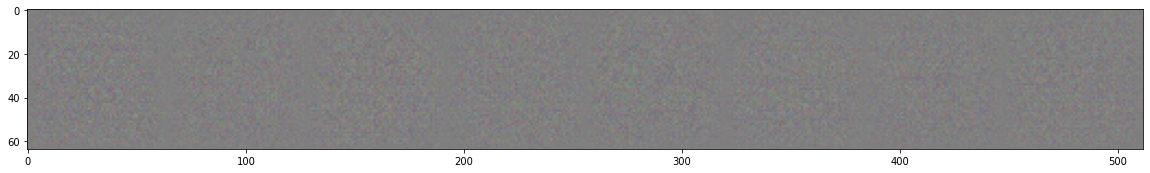

[1/3 - 1017/5086] Loss_D: 0.0582 Loss_G: 5.0424


<Figure size 432x288 with 0 Axes>

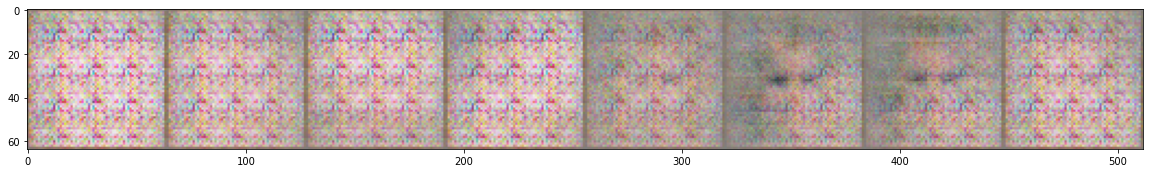

[1/3 - 2034/5086] Loss_D: 0.0464 Loss_G: 3.9457


<Figure size 432x288 with 0 Axes>

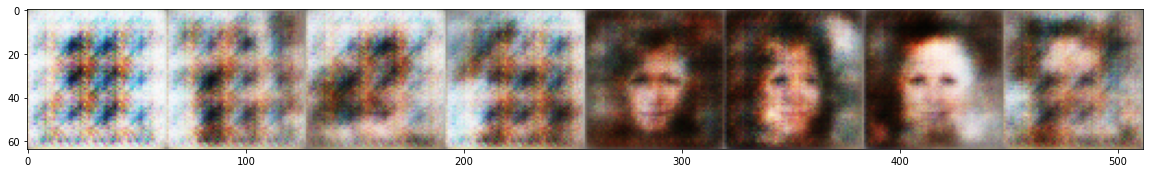

[1/3 - 3051/5086] Loss_D: 0.2104 Loss_G: 3.8027


<Figure size 432x288 with 0 Axes>

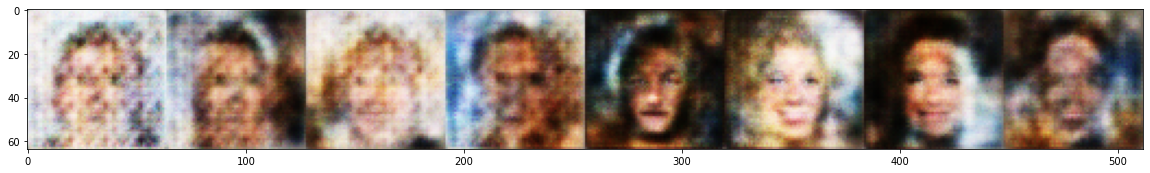

[1/3 - 4068/5086] Loss_D: 0.0881 Loss_G: 3.9681


<Figure size 432x288 with 0 Axes>

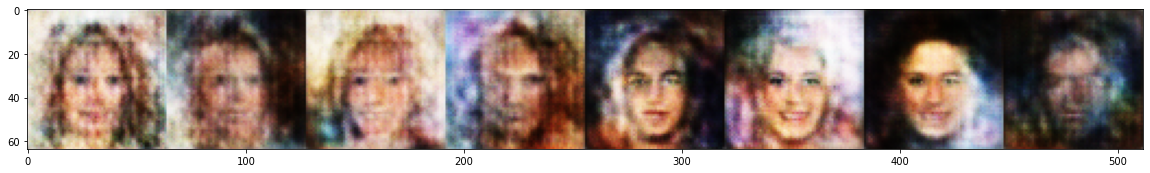

[1/3 - 5085/5086] Loss_D: 0.2281 Loss_G: 3.7424


<Figure size 432x288 with 0 Axes>

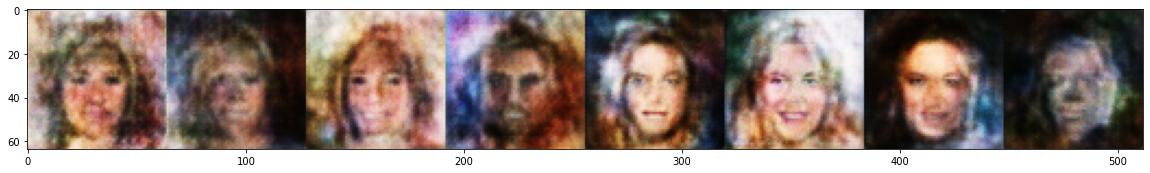

------------------------------
[2/3 - 0/5086] Loss_D: 0.1393 Loss_G: 4.3784


<Figure size 432x288 with 0 Axes>

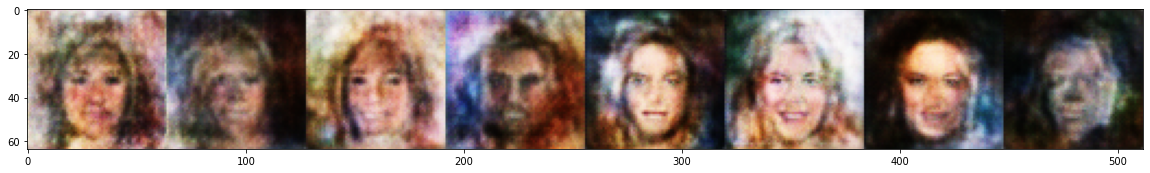

[2/3 - 1017/5086] Loss_D: 0.2143 Loss_G: 3.7312


<Figure size 432x288 with 0 Axes>

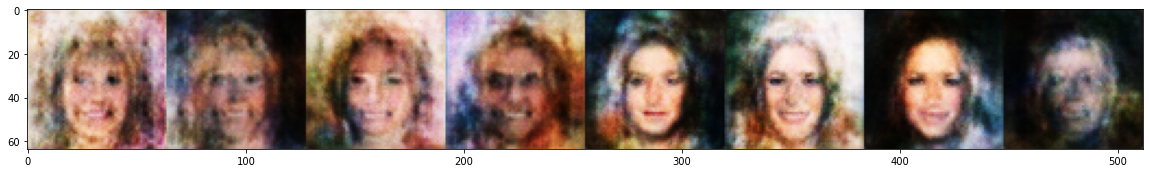

[2/3 - 2034/5086] Loss_D: 0.1983 Loss_G: 3.7136


<Figure size 432x288 with 0 Axes>

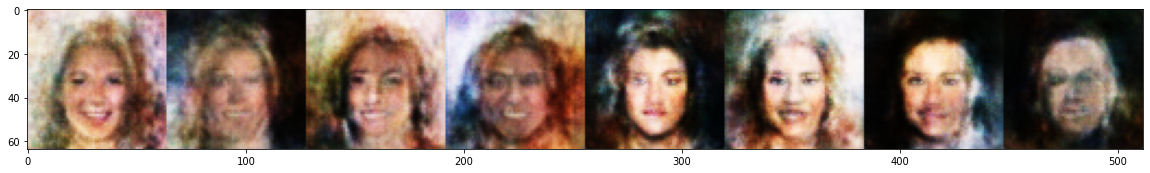

[2/3 - 3051/5086] Loss_D: 0.1132 Loss_G: 4.0151


<Figure size 432x288 with 0 Axes>

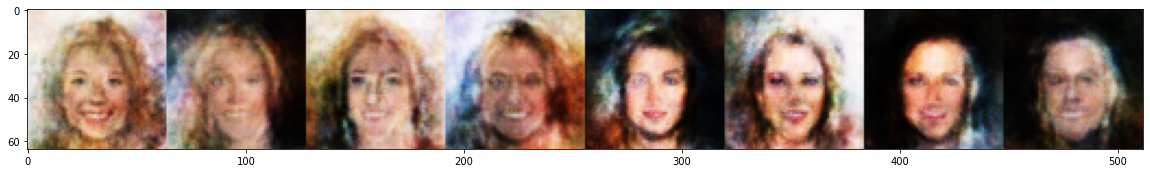

[2/3 - 4068/5086] Loss_D: 0.0884 Loss_G: 3.9722


<Figure size 432x288 with 0 Axes>

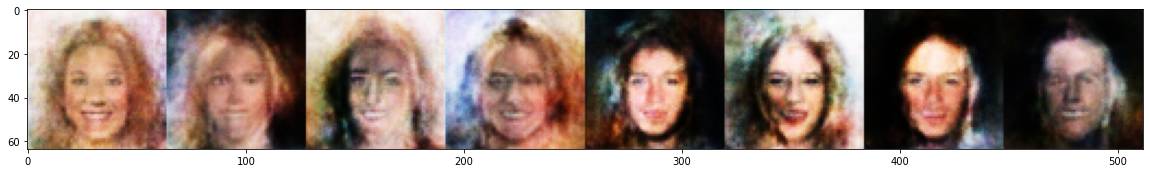

[2/3 - 5085/5086] Loss_D: 0.0796 Loss_G: 3.8274


<Figure size 432x288 with 0 Axes>

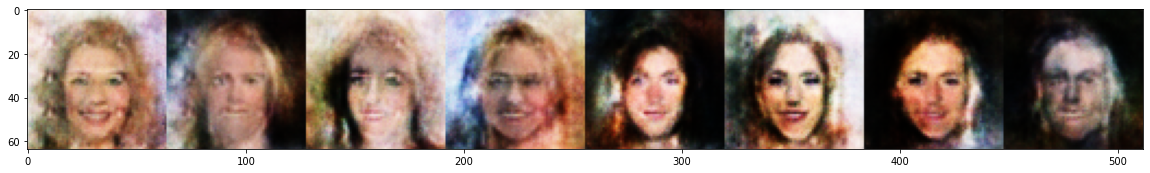

------------------------------
[3/3 - 0/5086] Loss_D: 0.0693 Loss_G: 3.8139


<Figure size 432x288 with 0 Axes>

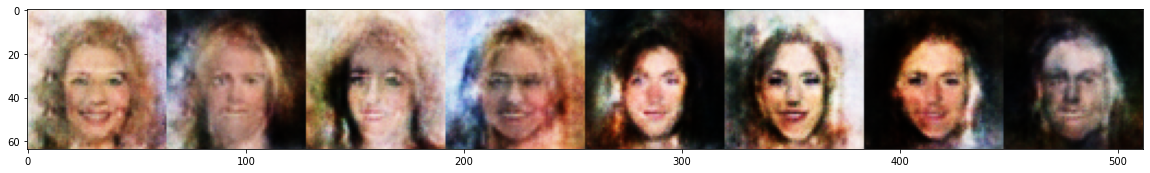

[3/3 - 1017/5086] Loss_D: 0.0946 Loss_G: 3.9016


<Figure size 432x288 with 0 Axes>

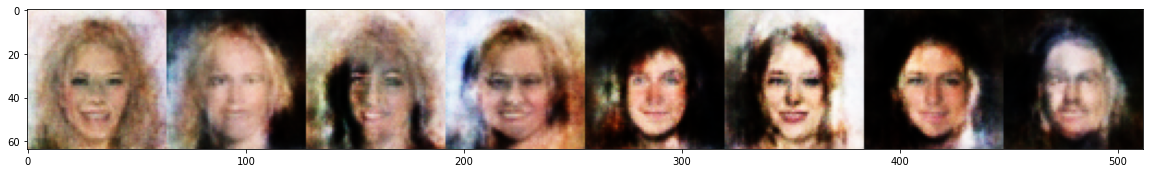

[3/3 - 2034/5086] Loss_D: 0.0908 Loss_G: 3.6532


<Figure size 432x288 with 0 Axes>

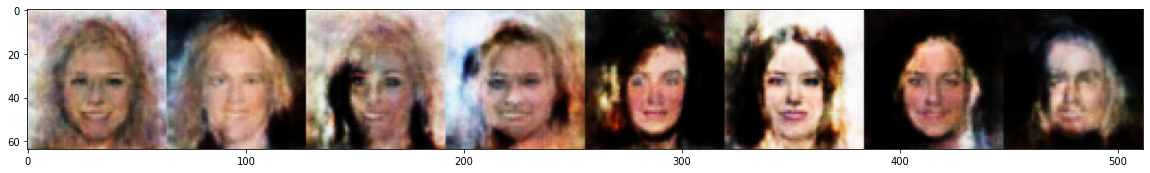

[3/3 - 3051/5086] Loss_D: 0.0503 Loss_G: 4.0502


<Figure size 432x288 with 0 Axes>

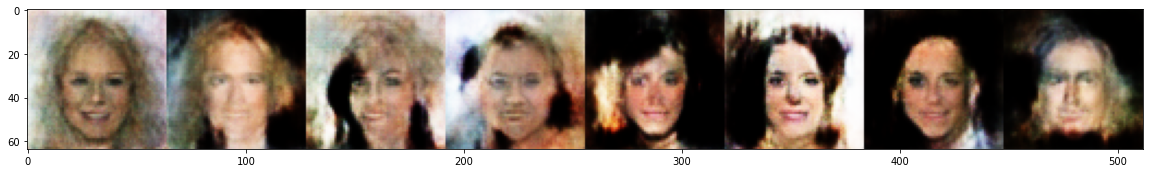

[3/3 - 4068/5086] Loss_D: 0.0708 Loss_G: 3.9351


<Figure size 432x288 with 0 Axes>

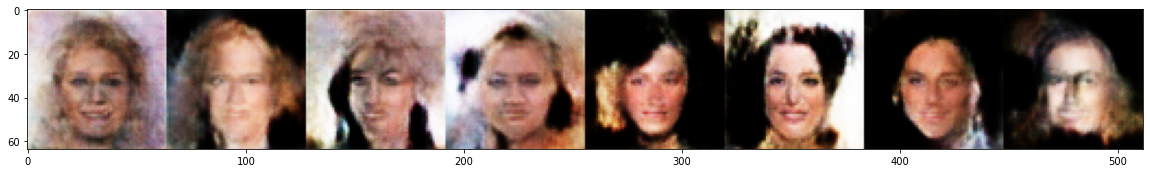

[3/3 - 5085/5086] Loss_D: 0.1396 Loss_G: 4.2643


<Figure size 432x288 with 0 Axes>

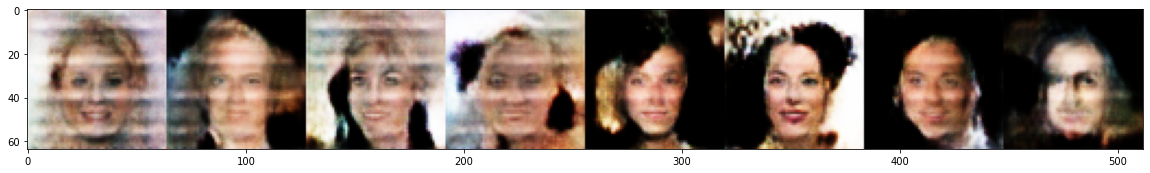

------------------------------
avg loss d 0.1396186351776123
avg loss d 4.264328479766846
avg time 1389.2186772028606 secs


<Figure size 432x288 with 0 Axes>

In [ ]:
log_step = int(len(dataset) * 0.2)
from tqdm import tqdm
import time
t = time.time()

for epoch in range(start_epoch, max_epoch + 1):
    d_loss_list = []
    g_loss_list = []
    for i, (imgs, _) in  enumerate(dataset):
        loss_temp = {
            'err_d': [],
            'err_g': []
        }
        imgs = imgs.to(device)
        
        # ========== Update Discriminator ==========
        # ---------- You Should Modify ----------
        net_d.zero_grad()
        
        # throw real image into discriminator
        y_pred = net_d(imgs).view(-1)

        # generate fake image and throw it into discriminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = net_g(noise)
        y_pred_fake = net_d(fake_imgs.detach()).view(-1)

        # calculate loss
        ## 這邊使用了 Relativistic average LSGAN
        
        err_d = (torch.mean((y_pred - torch.mean(y_pred_fake) - real_label) ** 2) + torch.mean((y_pred_fake - torch.mean(y_pred) + real_label) ** 2))/2
        
        err_d.backward(retain_graph=True)
        loss_temp['err_d'].append(err_d.item())
        optim_d.step()
        
        # ========== Update Generator ==========
        # ---------- You Should Modify ----------
        net_g.zero_grad()
        
        # throw real and fake image into discirminator (Since we just updated Discriminator)
        y_pred_fake = net_d(fake_imgs).view(-1)
        y_pred = net_d(imgs).view(-1)

        
        err_g = (torch.mean((y_pred - torch.mean(y_pred_fake) + real_label) ** 2) + torch.mean((y_pred_fake - torch.mean(y_pred) - real_label) ** 2))/2
        
        err_g.backward()
        loss_temp['err_g'].append(err_g.item())

        optim_g.step()
        
        
        if i % log_step == 0:
            print('[{}/{} - {}/{}] Loss_D: {:.4f} Loss_G: {:.4f}'.format( # y_d: {:.4f} / {:.4f}
                epoch, max_epoch, i, len(dataset),
                err_d.item(), err_g.item(),# y_d_real, y_d_fake#, y_g_real, y_g_fake
            ))

            fix_fake_imgs = net_g(fixed_noise).cpu().detach()
            plot_imgs(fix_fake_imgs[:8], True, file_name='out_imgs/e{:02}.png'.format(epoch))
    
    print('-' * 30)
    l_d = sum(loss_temp['err_d']) / len(loss_temp['err_d'])
    l_g = sum(loss_temp['err_g']) / len(loss_temp['err_g'])
    d_loss_list.append(l_d)
    g_loss_list.append(l_g)
print('avg loss d', sum(d_loss_list) / len(d_loss_list))
print('avg loss d', sum(g_loss_list) / len(g_loss_list))
t = time.time() - t
print('avg time', t / max_epoch, 'secs')